In [2]:
import xarray as xa
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# calculating geopotential at each model level

https://www.ecmwf.int/sites/default/files/elibrary/2015/9210-part-iii-dynamics-and-numerical-procedures.pdf

also saved to literature/ifs

In [2]:
# ---------------------------------------------------------------------------------
# some gas constants
# source: http://glossary.ametsoc.org/wiki/Gas_constant
# ---------------------------------------------------------------------------------
R_D = 287.06    # dry air,     J K**-1 kg**-1
R_V = 461       # water vapor, J K**-1 kg**-1

lvlmax = 137         # 61 for ERAI, 137 for ERA5

# ---------------------------------------------------------------------------------
# source:  IFS Documentation - Cy41r1, Part III: Dynamics and Numerical Procedures
# 
# all equations referenced are found in this document
# ---------------------------------------------------------------------------------


# ----------------------------------------------
# function get_phikhalf
# ----------------------------------------------
# implementation of equation 2.21
# calculates geopotential at half layer k+1/2
# for half layer 137+1/2 this equals the geopotential at the surface
#
# parameters
#
# k      full level below which to calculate phi_(k+1/2) (half layer k+1/2)
#
# concerning half and full levels/layers:
#   (k+1/2 lies below full layer k)
# 
#   level 0.5 corresponds to the top of the atmosphere
#   level 137.5 to the surface
#   full levels range from 1 to 137
# ----------------------------------------------
def get_phikhalf(k):
    
    s  = 0                  # value of sum
    sp = era5_ds.sp.values  # surface pressure
    
    #print(k,' loop from ',k+1,' to ',lvlmax)
    
    for j in range(k+1,lvlmax+1):    
        #print ('   loop ',j)
        pu = get_p(j,-0.5)                    # pressure at half layer above (lower than pl)
        pl = get_p(j,+0.5)                    # pressure at half layer below (higher than pu)
        
        t  = era5_ds.sel(level=j)['t'].values # temperature at full level j
        q  = era5_ds.sel(level=j)['q'].values # specific humidity at full level j
        tv = t*(1+(R_V/R_D-1.0)*q)            # virtual temperature at full level j
        
        s+=R_D*tv*np.log(pl/pu)               # sum in eq. 2.21
        
    s += era5_ds.z.values                     # need to add geopotential at surface
    return s

# ----------------------------------------------
# function get_p
# ----------------------------------------------
# get pressure at half level
#
# k  ... full level
# hl ... which half level
#
# hl = +0.5 ... half level below (k+1/2)
# hl = -0.5 ... half level above (k-1/2)
# ----------------------------------------------
def get_p(k,hl):
    if hl == 0.5:
        h = 0
    elif hl == -0.5:
        h = -1
    else:
        print('error, hl needs to be +0.5 or -0.5')
        
    if (k < lvlmax) or ((k == lvlmax) and (h==-1)):
        a = ml_df.loc[k+h,'a [Pa]']
        b = ml_df.loc[k+h,'b']
        p = a+b*era5_ds.sp.values
    elif (k == lvlmax) and(h == 0):   # if the half level below 137 is request that's the surface pressure
        p = era5_ds.sp.values
        
    return p

# ----------------------------------------------
# function get_alpha
# ----------------------------------------------
# calculate coefficient alpha_k
# as given by equation 2.23
# ----------------------------------------------
def get_alpha(k):
    if k == 1:
        ak = np.log(2)
    else:
        pu = get_p(k,-0.5)
        pl = get_p(k,+0.5)
        
        deltapk = pl-pu
        
        ak = 1-(pu/deltapk)*np.log(pl/pu)
    return ak
  
    
    
# ----------------------------------------------
# function get_phi
# ----------------------------------------------
# calculate geopotential at full model level k
# as given by equation 2.22
# ----------------------------------------------
def get_phi(k):
    phikhl = get_phikhalf(k)
    ak    = get_alpha(k)

    t  = era5_ds.sel(level=k)['t'] # temperature at full level k
    q  = era5_ds.sel(level=k)['q'] # specific humidity at full level k
    tv = t*(1+(R_V/R_D-1.0)*q)     # virtual temperature at full level k
    
    phik = phikhl+ak*R_D*tv
    
    return phik

In [23]:
atm_ds = xa.open_dataset('./era5_tryouts/20150201-20150202_snz_tryout_atm.nc')
sfc_ds = xa.open_dataset('./era5_tryouts/20150201-20150202_snz_tryout_sfc.nc')

ml_df = pd.read_csv('./data/model_level.csv',index_col='n')

xmp_ds = xa.open_dataset('../../Documents/work/uibk/downscaling/NZ south island/ERAI/forcings/southern_nz_6a_icar-095_erai_165,176,-48,-40_31-01-2015-to-01-03-2015.nc')

In [24]:
# if necessary - download metadata about model levels
#ml_df = pd.read_html('https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels')[0]
#ml_df.to_csv('./data/model_level.csv',index=False)

In [25]:
#test whether surface and atmospheric dataset coordinates match

if False in (sfc_ds.time == atm_ds.time).values:
    print(' time dimension not matching')
    
if False in (sfc_ds.longitude == atm_ds.longitude).values:
    print(' longitude not matching')
    
if False in (sfc_ds.latitude == atm_ds.latitude).values:
    print(' latitude not matching')
    
era5_ds = atm_ds.merge(sfc_ds)

# -
# create a dataset that contains the ak and bk coefficients of ERA5
# later needed to calculate pressure at each model level from surface pressure
# -
ab_ds = xa.Dataset(
    coords={
        'level'        : era5_ds.level,
      #  'west_east'   : west_east,
      #  'south_north' : south_north
    },
    data_vars={
        'ak'     : (['level'],ml_df.loc[era5_ds.level.values,'a [Pa]'].values),
        'bk'     : (['level'],ml_df.loc[era5_ds.level.values,'b'].values),        
    }
)

era5_ds = era5_ds.merge(ab_ds)

In [26]:
Nt   = len(era5_ds.time)
Nlon = len(era5_ds.longitude)
Nlat = len(era5_ds.latitude)
Nlvl = len(era5_ds.level)

In [7]:
# concerning ERA5 levels.

# level 0   ... top of the atmosphere (pressure = 0)
# level 137 ... bottom of the atmosphere (surface, pressure = pS)
# in total: 138 model half levels (interfaces between 'full levels')

In [8]:
# first - calculate the pressure and geopotential (height) at every model level
# set pressure at level 0 (= top of the atmosphere) to nan. this shouldn't be a full level anymore
# and therefor we can't assign a pressure to it.

p           = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)  # pressure
ph          = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)  # geopotential height

for n in range(0,Nlvl):
    lvl  = era5_ds.level.values[n]
    ak0  = era5_ds.ak.values[n]        # coef. for half level below (higher pressure)
    bk0  = era5_ds.bk.values[n]
    
    if n > 0:
        ak1  = era5_ds.ak.values[n-1]  # coef. for half level above (lower pressure)
        bk1  = era5_ds.bk.values[n-1]
    else:
        # for n = 0 we have to look up the ak and bk values from
        # the ml_df dataframe since we did not store those in the xarray
        # dataset. we do this only if lvl > 0, otherwise it doesn't matter
        # since the pressure at full-lvl = 0 cannot be specified anyways
        if lvl > 0:
            ak1  = ml_df.loc[lvl-1,'a [Pa]']
            bk1  = ml_df.loc[lvl-1,'b']
        
    
    ps  = era5_ds.sp[:].values
    print('{:4n} {:4n} | {:10.4f} {:10.4f} | {:10.4f} {:10.4f} |'.format(n,lvl,ak0,bk0,ak1,bk1))
    
    ph[:,n] = get_phi(lvl)/9.81   # get_phi calculates geopotential at full model level
    
    if lvl == 0:
        p[:,n] = ps*np.nan
    else:
        p[:,n] = 0.5*((ak0+bk0*ps)+(ak1+bk1*ps))
    
era5_ds['p'] = (['time','level','latitude','longitude'],p)
era5_ds['ph'] = (['time','level','latitude','longitude'],ph)

   0   30 |  1156.8536     0.0000 |  1037.2012     0.0000 |
   1   31 |  1285.6104     0.0000 |  1156.8536     0.0000 |
   2   32 |  1423.7701     0.0000 |  1285.6104     0.0000 |
   3   33 |  1571.6229     0.0000 |  1423.7701     0.0000 |
   4   34 |  1729.4490     0.0000 |  1571.6229     0.0000 |
   5   35 |  1897.5193     0.0000 |  1729.4490     0.0000 |
   6   36 |  2076.0959     0.0000 |  1897.5193     0.0000 |
   7   37 |  2265.4316     0.0000 |  2076.0959     0.0000 |
   8   38 |  2465.7705     0.0000 |  2265.4316     0.0000 |
   9   39 |  2677.3481     0.0000 |  2465.7705     0.0000 |
  10   40 |  2900.3914     0.0000 |  2677.3481     0.0000 |
  11   41 |  3135.1194     0.0000 |  2900.3914     0.0000 |
  12   42 |  3381.7437     0.0000 |  3135.1194     0.0000 |
  13   43 |  3640.4683     0.0000 |  3381.7437     0.0000 |
  14   44 |  3911.4905     0.0000 |  3640.4683     0.0000 |
  15   45 |  4194.9307     0.0000 |  3911.4905     0.0000 |
  16   46 |  4490.8174     0.0000 |  419

In [107]:
# prepare the arrays
west_east = range(0,Nlon)
south_north = range(0,Nlon)
bottom_top  = (lvlmax-era5_ds.level)[::-1]                    # reverse order, 137 is lowest level in ERA5, is here now 0

xlong       = np.zeros(Nt*Nlon*Nlat).reshape(Nt,Nlat,Nlon)
xlat        = np.zeros(Nt*Nlon*Nlat).reshape(Nt,Nlat,Nlon)
Time        = era5_ds.time.values

HGT         = np.zeros(Nt*Nlon*Nlat).reshape(Nt,Nlat,Nlon)             # elevation at surface
PH          = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)   # geopotential height
U           = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
V           = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
QVAPOR      = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
QCLOUD      = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
QICE        = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
PHB         = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)   # not used
PB          = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)   # not used

# set values
U          = era5_ds.u[:,::-1,::-1,:]
V          = era5_ds.v[:,::-1,::-1,:]
P          = era5_ds.p[:,::-1,::-1,:]
QVAPOR     = era5_ds.q[:,::-1,::-1,:]
QCLOUD     = era5_ds.clwc[:,::-1,::-1,:]
QICE       = era5_ds.ciwc[:,::-1,::-1,:]
PH         = era5_ds.ph[:,::-1,::-1,:]
HGT        = era5_ds.z[:,::-1,:]/9.81

xlong[:,:] = era5_ds.longitude

for ny in range(Nlat):
    xlat[:,ny,:] = era5_ds.latitude[::-1].values[ny]

In [142]:
frc_ds = xa.Dataset(
    coords={
        'Time'        : Time,
      #  'west_east'   : west_east,
      #  'south_north' : south_north
    },
    data_vars={
        'XLONG'    : (['Time','south_north','west_east'],xlong),
        'XLAT'     : (['Time','south_north','west_east'],xlat),
        'HGT'      : (['Time','south_north','west_east'],HGT),
        'U'        : (['Time','bottom_top','south_north','west_east'],U),
        'V'        : (['Time','bottom_top','south_north','west_east'],V),
        'P'        : (['Time','bottom_top','south_north','west_east'],P),
        'PH'       : (['Time','bottom_top','south_north','west_east'],PH),
        'QVAPOR'   : (['Time','bottom_top','south_north','west_east'],QVAPOR),
        'QCLOUD'   : (['Time','bottom_top','south_north','west_east'],QCLOUD),
        'QICE'     : (['Time','bottom_top','south_north','west_east'],QICE),
        'PB'       : (['Time','bottom_top','south_north','west_east'],PB),
        'PHB'      : (['Time','bottom_top','south_north','west_east'],PHB),
        
    }
)

# copy the attributes of variables that have a correspondence in the era5 dataset

varmap=[
    ['u','U'],
    ['v','V'],
    ['q','QVAPOR'],
    ['clwc','QCLOUD'],
    ['ciwc','QICE']
]

frc_ds['P'].attrs['units']         = 'Pa'
frc_ds['P'].attrs['long_name']     = 'pressure'
frc_ds['P'].attrs['standard_name'] = 'pressure'

frc_ds['HGT'].attrs['units']         = 'm'
frc_ds['HGT'].attrs['long_name']     = 'geopotential height of orography surface'
frc_ds['HGT'].attrs['standard_name'] = 'surface_geopotential_height'

frc_ds['PH'].attrs['units']         = 'm'
frc_ds['PH'].attrs['long_name']     = 'geopotential height of grid cell'
frc_ds['PH'].attrs['standard_name'] = 'geopotential_height'

frc_ds['PB'].attrs['units']         = ''
frc_ds['PB'].attrs['long_name']     = 'unused variable'
frc_ds['PB'].attrs['standard_name'] = ''

frc_ds['PHB'].attrs['units']         = ''
frc_ds['PHB'].attrs['long_name']     = 'unused variable'
frc_ds['PHB'].attrs['standard_name'] = ''

for n in range(len(varmap)):
    row = varmap[n]
    eravar  = row[0]
    frcvar  = row[1]
    for key in era5_ds[eravar].attrs:
        val = era5_ds[eravar].attrs[key]
        frc_ds[frcvar].attrs[key] = val

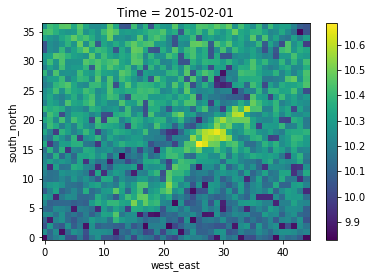

In [11]:
(frc_ds.PH[0,0]-frc_ds.HGT[0]).plot()

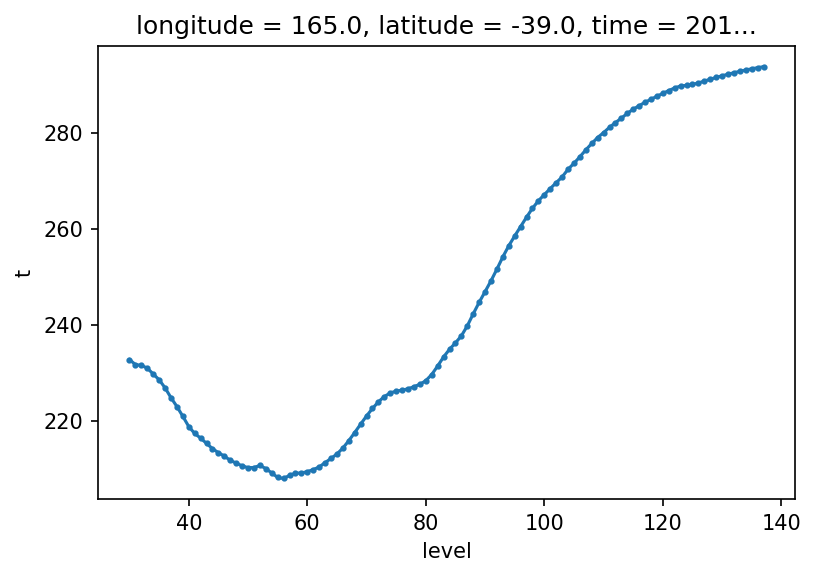

In [203]:
f,ax = plt.subplots(1,1,dpi=150)
era5_ds['t'][0,:,0,0].plot(marker='o',markersize=2)

[]

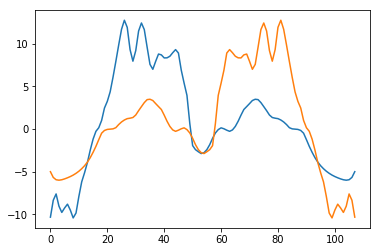

In [123]:
plt.plot(era5_ds.u[0,:,-1,0])
plt.plot(frc_ds.U[0,:,0,0])
plt.plot()

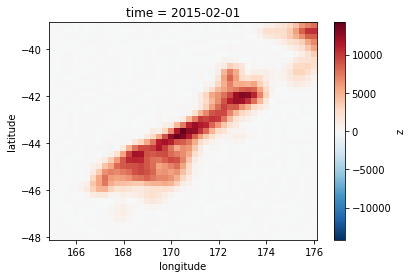

In [51]:
era5_ds.z[0].plot()

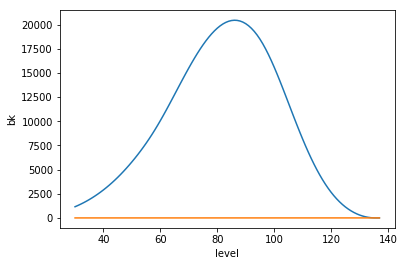

In [70]:
ab_ds.ak.plot()
ab_ds.bk.plot()

In [263]:
xmp_ds.data_vars

Data variables:
    XLONG    (Time, south_north, west_east) float32 ...
    XLAT     (Time, south_north, west_east) float32 ...
    U        (Time, bottom_top, south_north, west_east) float32 ...
    V        (Time, bottom_top, south_north, west_east) float32 ...
    PH       (Time, bottom_top, south_north, west_east) float32 ...
    T        (Time, bottom_top, south_north, west_east) float32 ...
    PB       (Time, bottom_top, south_north, west_east) float32 ...
    P        (Time, bottom_top, south_north, west_east) float32 101191.06 ...
    HGT      (Time, south_north, west_east) float32 ...
    PHB      (Time, bottom_top, south_north, west_east) float32 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 ...
    QCLOUD   (Time, bottom_top, south_north, west_east) float32 ...
    QICE     (Time, bottom_top, south_north, west_east) float32 ...
    TSK      (Time, bottom_top, south_north, west_east) float32 ...
    sp       (Time, south_north, west_east) float32 ...

In [21]:
era5_ds.data_vars

Data variables:
    t        (time, level, latitude, longitude) float32 ...
    q        (time, level, latitude, longitude) float32 ...
    w        (time, level, latitude, longitude) float32 ...
    d        (time, level, latitude, longitude) float32 ...
    clwc     (time, level, latitude, longitude) float32 ...
    ciwc     (time, level, latitude, longitude) float32 ...
    u        (time, level, latitude, longitude) float32 ...
    v        (time, level, latitude, longitude) float32 ...
    z        (time, latitude, longitude) float32 -3.6206055 3.2797852 10.625 ...
    sp       (time, latitude, longitude) float32 100574.88 100592.85 ...
    ak       (level) float64 1.157e+03 1.286e+03 1.424e+03 1.572e+03 ...
    bk       (level) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    p        (time, level, latitude, longitude) float64 1.097e+03 1.097e+03 ...
    ph       (time, level, latitude, longitude) float64 3.058e+04 3.058e+04 ...

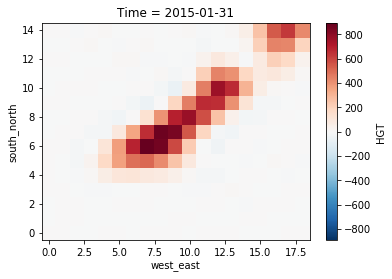

In [264]:
xmp_ds.HGT[0,:].plot()

In [265]:
xmp_ds

<xarray.Dataset>
Dimensions:  (Time: 124, bottom_top: 60, south_north: 15, west_east: 19)
Coordinates:
  * Time     (Time) datetime64[ns] 2015-01-31 2015-01-31T06:00:00 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    XLONG    (Time, south_north, west_east) float32 ...
    XLAT     (Time, south_north, west_east) float32 ...
    U        (Time, bottom_top, south_north, west_east) float32 ...
    V        (Time, bottom_top, south_north, west_east) float32 ...
    PH       (Time, bottom_top, south_north, west_east) float32 ...
    T        (Time, bottom_top, south_north, west_east) float32 ...
    PB       (Time, bottom_top, south_north, west_east) float32 ...
    P        (Time, bottom_top, south_north, west_east) float32 101191.06 ...
    HGT      (Time, south_north, west_east) float32 ...
    PHB      (Time, bottom_top, south_north, west_east) float32 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 ...
    QCLOUD   (Time, bo

In [267]:
era5_ds.q

<xarray.DataArray 'q' (time: 48, level: 108, latitude: 37, longitude: 45)>
[8631360 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 165.0 165.25 165.5 165.75 166.0 166.25 ...
  * latitude   (latitude) float32 -39.0 -39.25 -39.5 -39.75 -40.0 -40.25 ...
  * level      (level) int32 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 ...
  * time       (time) datetime64[ns] 2015-02-01 2015-02-01T01:00:00 ...
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

In [161]:
get_phi(137)[0][::-1,:]

<xarray.DataArray (latitude: 37, longitude: 45)>
array([[   95.90095 ,   104.358376,    96.1516  , ...,    96.53362 ,
           96.0847  ,   104.770706],
       [  102.93971 ,    99.35354 ,   104.856834, ...,    96.88467 ,
           95.3235  ,   104.81903 ],
       [   99.632416,    99.71702 ,   104.655685, ...,   101.39021 ,
          104.23714 ,    94.94145 ],
       ...,
       [   98.81119 ,    93.90851 ,   103.34338 , ...,  6647.3105  ,
         8439.385   ,  8589.889   ],
       [  105.92484 ,   110.08734 ,    95.91563 , ...,  8523.38    ,
        10398.792   , 10447.485   ],
       [   97.049706,   105.46575 ,   112.4656  , ...,  6356.236   ,
         7169.039   ,  7893.4873  ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 165.0 165.25 165.5 165.75 166.0 166.25 ...
  * latitude   (latitude) float32 -48.0 -47.75 -47.5 -47.25 -47.0 -46.75 ...
    level      int32 137
    time       datetime64[ns] 2015-02-01

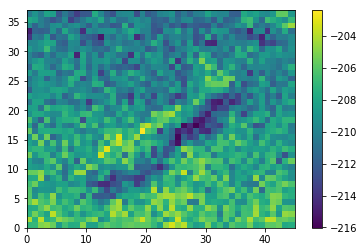

In [162]:
pcm =  plt.pcolormesh(get_phi(137)[0][::-1,:]-get_phi(136)[0][::-1,:])
plt.colorbar(pcm)
print('')

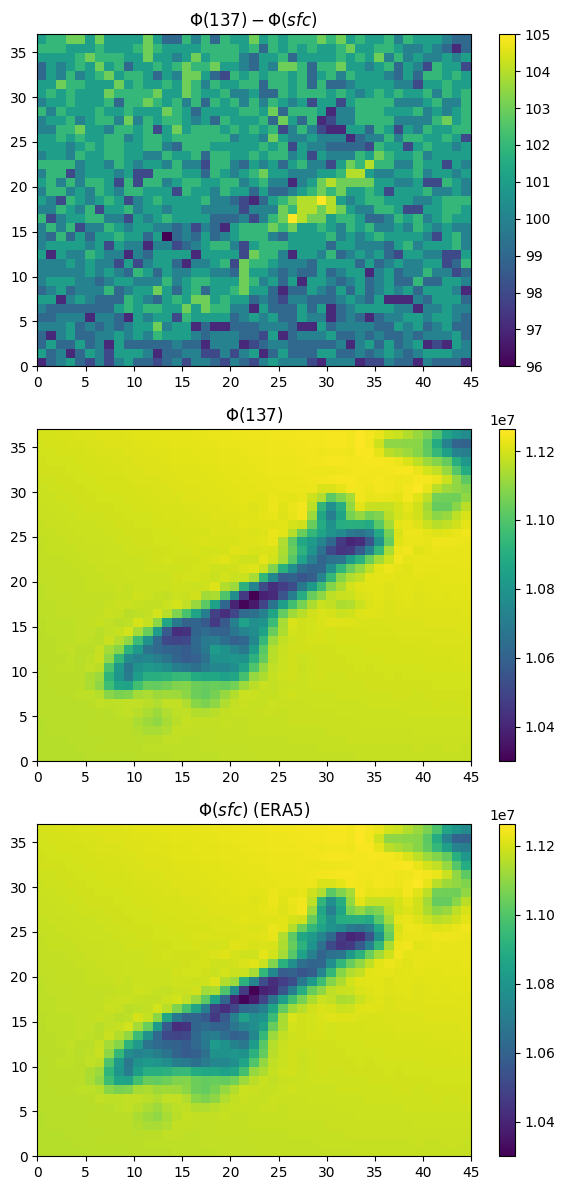

In [195]:
f, axarr = plt.subplots(3,1,figsize=(6,12),dpi=100)
pcm =  axarr[0].pcolormesh(get_phi(137)[0][::-1,:]-era5_ds.z[0][::-1,:])
axarr[0].set_title('$\Phi(137)-\Phi(sfc)$ ')
f.colorbar(pcm,ax=axarr[0])

pcm =  axarr[1].pcolormesh(get_phi(137)[0][::-1,:])
axarr[1].set_title('$\Phi(137)$')
f.colorbar(pcm,ax=axarr[1])

pcm =  axarr[2].pcolormesh(era5_ds.z[0][::-1,:])
axarr[2].set_title('$\Phi(sfc)$ (ERA5)')
f.colorbar(pcm,ax=axarr[2])

plt.tight_layout()

In [196]:
era5_ds.z

<xarray.DataArray 'z' (time: 48, latitude: 37, longitude: 45)>
array([[[11201124., 11202308., ..., 10806171., 10763830.],
        [11198396., 11199618., ..., 10605748., 10600737.],
        ...,
        [11155310., 11156410., ..., 11180299., 11179391.],
        [11154794., 11155192., ..., 11178073., 11177034.]],

       [[11200491., 11201688., ..., 10805394., 10763309.],
        [11197706., 11199081., ..., 10604999., 10600165.],
        ...,
        [11156046., 11156711., ..., 11181342., 11180590.],
        [11155576., 11155765., ..., 11179194., 11178558.]],

       ...,

       [[11220580., 11219729., ..., 10781729., 10742061.],
        [11216705., 11216263., ..., 10576651., 10574299.],
        ...,
        [11035749., 11035187., ..., 11047742., 11049683.],
        [11030019., 11028878., ..., 11044383., 11045974.]],

       [[11221786., 11220980., ..., 10782596., 10742499.],
        [11217540., 11217175., ..., 10576928., 10574020.],
        ...,
        [11039655., 11038740., ..., 1103

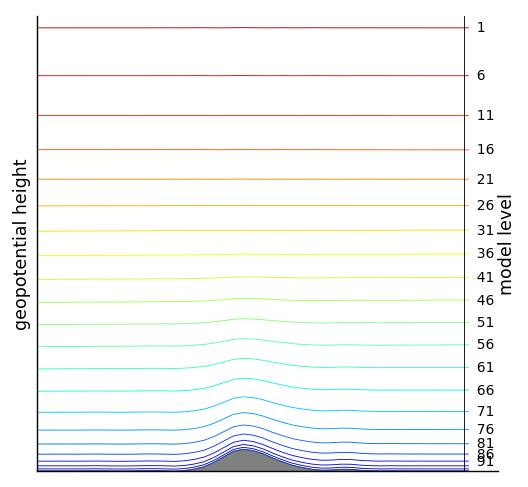

In [106]:
yn = 17
f,ax = plt.subplots(1,1,dpi=125)

cmap = mpl.cm.get_cmap('jet')

rgba = cmap(0.5)
dn=5
lvlstoplot =range(0,len(frc_ds.bottom_top),dn)

for n in lvlstoplot:
    rgba = cmap((float(n)/float(dn))/float(len(lvlstoplot)))
    
    x = (frc_ds.sel(south_north=yn).sel(bottom_top=n).west_east).values[-1]
    y = (frc_ds.sel(south_north=yn).sel(bottom_top=n).PH[0]/1000.0).values[-1]
    
    
    (frc_ds.sel(south_north=yn).sel(bottom_top=n).PH[0]/1000.0).plot(ax=ax,linewidth=0.5,c=rgba)
    if (106-n) <= 91:
        ax.annotate('  '+str(106-n),(x,y),fontsize=8,va='center')
    #(frc_ds.sel(south_north=yn).sel(bottom_top=n).P[0]/100.0).plot(ax=ax,linewidth=0.25,c=rgba)
    
(frc_ds.sel(south_north=yn).HGT[0]/1000.0).plot(ax=ax,linewidth=0.25)
plt.fill_between(x=frc_ds.sel(south_north=yn).west_east,y1=0,y2=frc_ds.sel(south_north=yn).HGT[0]/1000.0,facecolor='gray')
ax.set_ylim(0,30)
ax.set_ylabel('geopotential height')
ax.set_xlabel('')
ax.set_xlim(0,x+3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvline(x=x-0.5,c='black',lw=0.5)
ax.text(1.02,0.5,'model level', transform=ax.transAxes,rotation=90,horizontalalignment='center',verticalalignment='center')
ax.set_aspect(1.55)
plt.tight_layout()

plt.savefig('./era5_model_level_illustration.png')

In [38]:
y

44

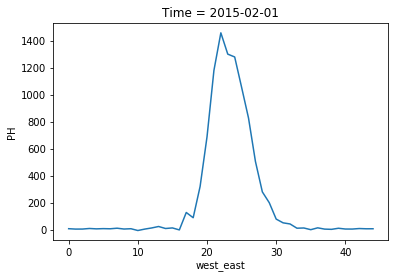

In [65]:
frc_ds.sel(south_north=18).PH[0,0].plot()

In [68]:
frc_ds

<xarray.Dataset>
Dimensions:  (Time: 48, bottom_top: 108, south_north: 37, west_east: 45)
Coordinates:
  * Time     (Time) datetime64[ns] 2015-02-01 2015-02-01T01:00:00 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    XLONG    (Time, south_north, west_east) float64 165.0 165.2 165.5 165.8 ...
    XLAT     (Time, south_north, west_east) float64 -48.0 -48.0 -48.0 -48.0 ...
    HGT      (Time, south_north, west_east) float32 -0.07411323 0.5158559 ...
    U        (Time, bottom_top, south_north, west_east) float32 -4.999256 ...
    V        (Time, bottom_top, south_north, west_east) float32 -1.8993554 ...
    P        (Time, bottom_top, south_north, west_east) float64 1.002e+05 ...
    PH       (Time, bottom_top, south_north, west_east) float64 9.776 10.64 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 0.009683361 ...
    QCLOUD   (Time, bottom_top, south_north, west_east) float32 0.0 0.0 0.0 ...
    QICE     (Time, bottom_top,

In [55]:
era5_ds

<xarray.Dataset>
Dimensions:    (latitude: 37, level: 108, longitude: 45, time: 48)
Coordinates:
  * longitude  (longitude) float32 165.0 165.25 165.5 165.75 166.0 166.25 ...
  * latitude   (latitude) float32 -39.0 -39.25 -39.5 -39.75 -40.0 -40.25 ...
  * level      (level) int32 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 ...
  * time       (time) datetime64[ns] 2015-02-01 2015-02-01T01:00:00 ...
Data variables:
    t          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    d          (time, level, latitude, longitude) float32 ...
    clwc       (time, level, latitude, longitude) float32 ...
    ciwc       (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 -3.6206055 3.2797852 ...
    sp 

In [4]:
# generate model level ml_df for ERAI
eraiab=xa.open_dataset('../erai2icar/data/ERA-Interim_coordvars.nc')

In [12]:
eraiab.a_interface

<xarray.DataArray 'a_interface' (lvlp1: 61)>
array([0.000000e+00, 2.000000e+01, 3.842530e+01, 6.364780e+01, 9.563700e+01,
       1.344830e+02, 1.805840e+02, 2.347790e+02, 2.984960e+02, 3.739720e+02,
       4.646180e+02, 5.756510e+02, 7.132180e+02, 8.836600e+02, 1.094830e+03,
       1.356470e+03, 1.680640e+03, 2.082270e+03, 2.579890e+03, 3.196420e+03,
       3.960290e+03, 4.906710e+03, 6.018020e+03, 7.306630e+03, 8.765050e+03,
       1.037612e+04, 1.207740e+04, 1.377530e+04, 1.537980e+04, 1.681950e+04,
       1.804520e+04, 1.902770e+04, 1.975510e+04, 2.022220e+04, 2.042990e+04,
       2.038450e+04, 2.009740e+04, 1.958430e+04, 1.886480e+04, 1.796140e+04,
       1.689950e+04, 1.570640e+04, 1.441110e+04, 1.304320e+04, 1.163280e+04,
       1.020950e+04, 8.802360e+03, 7.438800e+03, 6.144320e+03, 4.941780e+03,
       3.850910e+03, 2.887700e+03, 2.063780e+03, 1.385910e+03, 8.553620e+02,
       4.673330e+02, 2.103940e+02, 6.588920e+01, 7.367740e+00, 0.000000e+00,
       0.000000e+00], dtype=flo

In [11]:
eraiab.b_interface

<xarray.DataArray 'b_interface' (lvlp1: 61)>
array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 7.58235e-05,
       4.61395e-04, 1.81516e-03, 5.08112e-03, 1.11429e-02, 2.06779e-02,
       3.41212e-02, 5.16904e-02, 7.35338e-02, 9.96747e-02, 1.30023e-01,
       1.64384e-01, 2.02476e-01, 2.43933e-01, 2.88323e-01, 3.35155e-01,
       3.83892e-01, 4.33963e-01, 4.84772e-01, 5.35710e-01, 5.86168e-01,
       6.35547e-01, 6.83269e-01, 7.28786e-01, 7.71597e-01, 8.11253e-01,
       8.47375e-01, 8.79657e-01, 9.07884e-01, 9.31940e-01, 9.51822e-01,
       9.67645e-01, 9.79663e-01, 9.88270e-01, 9.94019e-01, 9.97630e-01,
       1.00000e+00], dtype=float32)
Coordinates:
  * lvlp1    (lvlp1) int32 1 2 3 4 5 6 7 8

In [15]:
ml_df = pd.DataFrame(columns=['n','a [Pa]','b'])

In [19]:
ml_df['n']      = eraiab.lvlp1
ml_df['a [Pa]'] = eraiab.a_interface.values
ml_df['b']      = eraiab.b_interface.values
ml_df.set_index('n')
ml_df.to_csv('../erai2icar/data/model_level.csv',index=False)

# era5 request merge
requested parameters are potentially split up into multiple files (and over multiple time slices per file). How to best merge them?

In [6]:
e5_ds = xa.open_mfdataset('./201502/*.nc')

In [10]:
e5_ds.time

<xarray.DataArray 'time' (time: 864)>
array(['2015-01-26T00:00:00.000000000', '2015-01-26T01:00:00.000000000',
       '2015-01-26T02:00:00.000000000', ..., '2015-03-02T21:00:00.000000000',
       '2015-03-02T22:00:00.000000000', '2015-03-02T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-26 2015-01-26T01:00:00 ...
Attributes:
    long_name:  time